# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 18            
model_seed = 8           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3028 | Test Loss 2.2978 | accs Train 0.0833 Test 0.1117


Epoch 100/3000: Train Loss 0.0067 | Test Loss 0.9323 | accs Train 1.0000 Test 0.7230


Epoch 200/3000: Train Loss 0.0028 | Test Loss 0.9725 | accs Train 1.0000 Test 0.7236


Epoch 300/3000: Train Loss 0.0018 | Test Loss 0.9981 | accs Train 1.0000 Test 0.7232


Epoch 400/3000: Train Loss 0.0013 | Test Loss 1.0168 | accs Train 1.0000 Test 0.7235


Epoch 500/3000: Train Loss 0.0010 | Test Loss 1.0314 | accs Train 1.0000 Test 0.7238


Epoch 600/3000: Train Loss 0.0008 | Test Loss 1.0435 | accs Train 1.0000 Test 0.7236


Epoch 700/3000: Train Loss 0.0007 | Test Loss 1.0537 | accs Train 1.0000 Test 0.7235


Epoch 800/3000: Train Loss 0.0006 | Test Loss 1.0625 | accs Train 1.0000 Test 0.7237


Epoch 900/3000: Train Loss 0.0005 | Test Loss 1.0701 | accs Train 1.0000 Test 0.7231


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.0769 | accs Train 1.0000 Test 0.7228


Epoch 1100/3000: Train Loss 0.0004 | Test Loss 1.0830 | accs Train 1.0000 Test 0.7221


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.0884 | accs Train 1.0000 Test 0.7218


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.0934 | accs Train 1.0000 Test 0.7216


Epoch 1400/3000: Train Loss 0.0003 | Test Loss 1.0979 | accs Train 1.0000 Test 0.7218


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.1020 | accs Train 1.0000 Test 0.7224


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.1058 | accs Train 1.0000 Test 0.7221


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.1094 | accs Train 1.0000 Test 0.7219


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.1127 | accs Train 1.0000 Test 0.7220


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.1157 | accs Train 1.0000 Test 0.7220


Epoch 2000/3000: Train Loss 0.0002 | Test Loss 1.1185 | accs Train 1.0000 Test 0.7220


Epoch 2100/3000: Train Loss 0.0002 | Test Loss 1.1212 | accs Train 1.0000 Test 0.7217


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.1236 | accs Train 1.0000 Test 0.7220


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.1259 | accs Train 1.0000 Test 0.7216


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.1279 | accs Train 1.0000 Test 0.7220


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.1299 | accs Train 1.0000 Test 0.7221


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.1317 | accs Train 1.0000 Test 0.7222


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.1335 | accs Train 1.0000 Test 0.7225


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.1351 | accs Train 1.0000 Test 0.7228


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.1367 | accs Train 1.0000 Test 0.7230


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.1381 | accs Train 1.0000 Test 0.7230
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.2998 | Test Loss 2.2981 | accs Train 0.0917 Test 0.1107


Epoch 100/3000: Train Loss 0.1404 | Test Loss 0.4672 | accs Train 0.9767 Test 0.8584


Epoch 200/3000: Train Loss 0.0306 | Test Loss 0.5114 | accs Train 1.0000 Test 0.8612


Epoch 300/3000: Train Loss 0.0128 | Test Loss 0.5579 | accs Train 1.0000 Test 0.8596


Epoch 400/3000: Train Loss 0.0076 | Test Loss 0.5905 | accs Train 1.0000 Test 0.8589


Epoch 500/3000: Train Loss 0.0052 | Test Loss 0.6145 | accs Train 1.0000 Test 0.8582


Epoch 600/3000: Train Loss 0.0039 | Test Loss 0.6333 | accs Train 1.0000 Test 0.8588


Epoch 700/3000: Train Loss 0.0031 | Test Loss 0.6486 | accs Train 1.0000 Test 0.8592


Epoch 800/3000: Train Loss 0.0026 | Test Loss 0.6615 | accs Train 1.0000 Test 0.8594


Epoch 900/3000: Train Loss 0.0022 | Test Loss 0.6726 | accs Train 1.0000 Test 0.8597


Epoch 1000/3000: Train Loss 0.0019 | Test Loss 0.6822 | accs Train 1.0000 Test 0.8599


Epoch 1100/3000: Train Loss 0.0017 | Test Loss 0.6907 | accs Train 1.0000 Test 0.8602


Epoch 1200/3000: Train Loss 0.0015 | Test Loss 0.6984 | accs Train 1.0000 Test 0.8605


Epoch 1300/3000: Train Loss 0.0014 | Test Loss 0.7052 | accs Train 1.0000 Test 0.8605


Epoch 1400/3000: Train Loss 0.0012 | Test Loss 0.7115 | accs Train 1.0000 Test 0.8606


Epoch 1500/3000: Train Loss 0.0011 | Test Loss 0.7172 | accs Train 1.0000 Test 0.8602


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.7224 | accs Train 1.0000 Test 0.8601


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.7272 | accs Train 1.0000 Test 0.8601


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.7316 | accs Train 1.0000 Test 0.8602


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.7357 | accs Train 1.0000 Test 0.8602


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.7396 | accs Train 1.0000 Test 0.8601


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.7432 | accs Train 1.0000 Test 0.8602


Epoch 2200/3000: Train Loss 0.0007 | Test Loss 0.7465 | accs Train 1.0000 Test 0.8602


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.7496 | accs Train 1.0000 Test 0.8602


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.7526 | accs Train 1.0000 Test 0.8599


Epoch 2500/3000: Train Loss 0.0006 | Test Loss 0.7554 | accs Train 1.0000 Test 0.8598


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.7580 | accs Train 1.0000 Test 0.8598


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.7604 | accs Train 1.0000 Test 0.8599


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.7628 | accs Train 1.0000 Test 0.8599


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.7649 | accs Train 1.0000 Test 0.8599


Epoch 3000/3000: Train Loss 0.0005 | Test Loss 0.7670 | accs Train 1.0000 Test 0.8598
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.2986 | Test Loss 2.2981 | accs Train 0.1035 Test 0.1107


Epoch 100/3000: Train Loss 0.2711 | Test Loss 0.3922 | accs Train 0.9230 Test 0.8866


Epoch 200/3000: Train Loss 0.1326 | Test Loss 0.3577 | accs Train 0.9700 Test 0.8995


Epoch 300/3000: Train Loss 0.0704 | Test Loss 0.3702 | accs Train 0.9890 Test 0.9010


Epoch 400/3000: Train Loss 0.0378 | Test Loss 0.3909 | accs Train 0.9980 Test 0.9009


Epoch 500/3000: Train Loss 0.0223 | Test Loss 0.4114 | accs Train 0.9995 Test 0.8999


Epoch 600/3000: Train Loss 0.0148 | Test Loss 0.4284 | accs Train 1.0000 Test 0.9010


Epoch 700/3000: Train Loss 0.0106 | Test Loss 0.4427 | accs Train 1.0000 Test 0.9009


Epoch 800/3000: Train Loss 0.0082 | Test Loss 0.4547 | accs Train 1.0000 Test 0.9014


Epoch 900/3000: Train Loss 0.0065 | Test Loss 0.4648 | accs Train 1.0000 Test 0.9016


Epoch 1000/3000: Train Loss 0.0054 | Test Loss 0.4735 | accs Train 1.0000 Test 0.9021


Epoch 1100/3000: Train Loss 0.0046 | Test Loss 0.4811 | accs Train 1.0000 Test 0.9022


Epoch 1200/3000: Train Loss 0.0039 | Test Loss 0.4878 | accs Train 1.0000 Test 0.9022


Epoch 1300/3000: Train Loss 0.0035 | Test Loss 0.4939 | accs Train 1.0000 Test 0.9025


Epoch 1400/3000: Train Loss 0.0031 | Test Loss 0.4993 | accs Train 1.0000 Test 0.9027


Epoch 1500/3000: Train Loss 0.0028 | Test Loss 0.5042 | accs Train 1.0000 Test 0.9030


Epoch 1600/3000: Train Loss 0.0025 | Test Loss 0.5087 | accs Train 1.0000 Test 0.9029


Epoch 1700/3000: Train Loss 0.0023 | Test Loss 0.5128 | accs Train 1.0000 Test 0.9033


Epoch 1800/3000: Train Loss 0.0021 | Test Loss 0.5166 | accs Train 1.0000 Test 0.9032


Epoch 1900/3000: Train Loss 0.0020 | Test Loss 0.5200 | accs Train 1.0000 Test 0.9033


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.5232 | accs Train 1.0000 Test 0.9036


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.5262 | accs Train 1.0000 Test 0.9035


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.5289 | accs Train 1.0000 Test 0.9036


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.5315 | accs Train 1.0000 Test 0.9038


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.5339 | accs Train 1.0000 Test 0.9036


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.5361 | accs Train 1.0000 Test 0.9036


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.5383 | accs Train 1.0000 Test 0.9037


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.5402 | accs Train 1.0000 Test 0.9037


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.5421 | accs Train 1.0000 Test 0.9038


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.5438 | accs Train 1.0000 Test 0.9038


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.5455 | accs Train 1.0000 Test 0.9038
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.2987 | Test Loss 2.2981 | accs Train 0.1063 Test 0.1103


Epoch 100/3000: Train Loss 0.3491 | Test Loss 0.3581 | accs Train 0.8992 Test 0.8967


Epoch 200/3000: Train Loss 0.2332 | Test Loss 0.2844 | accs Train 0.9357 Test 0.9170


Epoch 300/3000: Train Loss 0.1724 | Test Loss 0.2553 | accs Train 0.9542 Test 0.9236


Epoch 400/3000: Train Loss 0.1282 | Test Loss 0.2374 | accs Train 0.9688 Test 0.9292


Epoch 500/3000: Train Loss 0.0946 | Test Loss 0.2260 | accs Train 0.9788 Test 0.9344


Epoch 600/3000: Train Loss 0.0688 | Test Loss 0.2195 | accs Train 0.9863 Test 0.9353


Epoch 700/3000: Train Loss 0.0498 | Test Loss 0.2169 | accs Train 0.9918 Test 0.9371


Epoch 800/3000: Train Loss 0.0363 | Test Loss 0.2168 | accs Train 0.9963 Test 0.9397


Epoch 900/3000: Train Loss 0.0268 | Test Loss 0.2181 | accs Train 0.9980 Test 0.9410


Epoch 1000/3000: Train Loss 0.0203 | Test Loss 0.2202 | accs Train 0.9995 Test 0.9415


Epoch 1100/3000: Train Loss 0.0159 | Test Loss 0.2226 | accs Train 0.9998 Test 0.9417


Epoch 1200/3000: Train Loss 0.0128 | Test Loss 0.2252 | accs Train 1.0000 Test 0.9419


Epoch 1300/3000: Train Loss 0.0106 | Test Loss 0.2276 | accs Train 1.0000 Test 0.9418


Epoch 1400/3000: Train Loss 0.0090 | Test Loss 0.2300 | accs Train 1.0000 Test 0.9423


Epoch 1500/3000: Train Loss 0.0077 | Test Loss 0.2323 | accs Train 1.0000 Test 0.9425


Epoch 1600/3000: Train Loss 0.0067 | Test Loss 0.2344 | accs Train 1.0000 Test 0.9426


Epoch 1700/3000: Train Loss 0.0060 | Test Loss 0.2363 | accs Train 1.0000 Test 0.9430


Epoch 1800/3000: Train Loss 0.0053 | Test Loss 0.2382 | accs Train 1.0000 Test 0.9432


Epoch 1900/3000: Train Loss 0.0048 | Test Loss 0.2399 | accs Train 1.0000 Test 0.9433


Epoch 2000/3000: Train Loss 0.0044 | Test Loss 0.2415 | accs Train 1.0000 Test 0.9434


Epoch 2100/3000: Train Loss 0.0040 | Test Loss 0.2429 | accs Train 1.0000 Test 0.9436


Epoch 2200/3000: Train Loss 0.0037 | Test Loss 0.2443 | accs Train 1.0000 Test 0.9437


Epoch 2300/3000: Train Loss 0.0034 | Test Loss 0.2456 | accs Train 1.0000 Test 0.9437


Epoch 2400/3000: Train Loss 0.0032 | Test Loss 0.2469 | accs Train 1.0000 Test 0.9439


Epoch 2500/3000: Train Loss 0.0030 | Test Loss 0.2480 | accs Train 1.0000 Test 0.9440


Epoch 2600/3000: Train Loss 0.0028 | Test Loss 0.2491 | accs Train 1.0000 Test 0.9441


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2501 | accs Train 1.0000 Test 0.9441


Epoch 2800/3000: Train Loss 0.0025 | Test Loss 0.2511 | accs Train 1.0000 Test 0.9443


Epoch 2900/3000: Train Loss 0.0024 | Test Loss 0.2520 | accs Train 1.0000 Test 0.9443


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2528 | accs Train 1.0000 Test 0.9443
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.2996 | Test Loss 2.2981 | accs Train 0.1041 Test 0.1104


Epoch 100/3000: Train Loss 0.3528 | Test Loss 0.3491 | accs Train 0.8967 Test 0.8985


Epoch 200/3000: Train Loss 0.2577 | Test Loss 0.2683 | accs Train 0.9254 Test 0.9226


Epoch 300/3000: Train Loss 0.2106 | Test Loss 0.2318 | accs Train 0.9385 Test 0.9319


Epoch 400/3000: Train Loss 0.1758 | Test Loss 0.2047 | accs Train 0.9495 Test 0.9393


Epoch 500/3000: Train Loss 0.1481 | Test Loss 0.1834 | accs Train 0.9576 Test 0.9453


Epoch 600/3000: Train Loss 0.1254 | Test Loss 0.1666 | accs Train 0.9635 Test 0.9499


Epoch 700/3000: Train Loss 0.1066 | Test Loss 0.1536 | accs Train 0.9698 Test 0.9532


Epoch 800/3000: Train Loss 0.0909 | Test Loss 0.1434 | accs Train 0.9749 Test 0.9557


Epoch 900/3000: Train Loss 0.0778 | Test Loss 0.1355 | accs Train 0.9796 Test 0.9579


Epoch 1000/3000: Train Loss 0.0667 | Test Loss 0.1292 | accs Train 0.9836 Test 0.9615


Epoch 1100/3000: Train Loss 0.0574 | Test Loss 0.1243 | accs Train 0.9870 Test 0.9624


Epoch 1200/3000: Train Loss 0.0495 | Test Loss 0.1204 | accs Train 0.9894 Test 0.9630


Epoch 1300/3000: Train Loss 0.0428 | Test Loss 0.1173 | accs Train 0.9919 Test 0.9637


Epoch 1400/3000: Train Loss 0.0370 | Test Loss 0.1151 | accs Train 0.9938 Test 0.9646


Epoch 1500/3000: Train Loss 0.0322 | Test Loss 0.1134 | accs Train 0.9951 Test 0.9654


Epoch 1600/3000: Train Loss 0.0280 | Test Loss 0.1122 | accs Train 0.9960 Test 0.9659


Epoch 1700/3000: Train Loss 0.0244 | Test Loss 0.1113 | accs Train 0.9972 Test 0.9662


Epoch 1800/3000: Train Loss 0.0214 | Test Loss 0.1107 | accs Train 0.9978 Test 0.9665


Epoch 1900/3000: Train Loss 0.0188 | Test Loss 0.1104 | accs Train 0.9982 Test 0.9667


Epoch 2000/3000: Train Loss 0.0167 | Test Loss 0.1103 | accs Train 0.9986 Test 0.9670


Epoch 2100/3000: Train Loss 0.0148 | Test Loss 0.1104 | accs Train 0.9989 Test 0.9672


Epoch 2200/3000: Train Loss 0.0132 | Test Loss 0.1105 | accs Train 0.9992 Test 0.9675


Epoch 2300/3000: Train Loss 0.0119 | Test Loss 0.1107 | accs Train 0.9993 Test 0.9680


Epoch 2400/3000: Train Loss 0.0107 | Test Loss 0.1110 | accs Train 0.9995 Test 0.9682


Epoch 2500/3000: Train Loss 0.0097 | Test Loss 0.1114 | accs Train 0.9997 Test 0.9683


Epoch 2600/3000: Train Loss 0.0088 | Test Loss 0.1117 | accs Train 0.9997 Test 0.9683


Epoch 2700/3000: Train Loss 0.0081 | Test Loss 0.1121 | accs Train 0.9998 Test 0.9684


Epoch 2800/3000: Train Loss 0.0075 | Test Loss 0.1125 | accs Train 0.9999 Test 0.9687


Epoch 2900/3000: Train Loss 0.0069 | Test Loss 0.1129 | accs Train 0.9999 Test 0.9688


Epoch 3000/3000: Train Loss 0.0064 | Test Loss 0.1132 | accs Train 0.9999 Test 0.9688
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.2994 | Test Loss 2.2981 | accs Train 0.1067 Test 0.1103


Epoch 100/3000: Train Loss 0.3625 | Test Loss 0.3475 | accs Train 0.8942 Test 0.8999


Epoch 200/3000: Train Loss 0.2721 | Test Loss 0.2640 | accs Train 0.9209 Test 0.9246


Epoch 300/3000: Train Loss 0.2278 | Test Loss 0.2246 | accs Train 0.9343 Test 0.9343


Epoch 400/3000: Train Loss 0.1949 | Test Loss 0.1951 | accs Train 0.9448 Test 0.9443


Epoch 500/3000: Train Loss 0.1687 | Test Loss 0.1715 | accs Train 0.9517 Test 0.9497


Epoch 600/3000: Train Loss 0.1475 | Test Loss 0.1525 | accs Train 0.9579 Test 0.9539


Epoch 700/3000: Train Loss 0.1302 | Test Loss 0.1373 | accs Train 0.9628 Test 0.9585


Epoch 800/3000: Train Loss 0.1158 | Test Loss 0.1251 | accs Train 0.9668 Test 0.9625


Epoch 900/3000: Train Loss 0.1038 | Test Loss 0.1151 | accs Train 0.9708 Test 0.9653


Epoch 1000/3000: Train Loss 0.0936 | Test Loss 0.1069 | accs Train 0.9736 Test 0.9678


Epoch 1100/3000: Train Loss 0.0848 | Test Loss 0.1002 | accs Train 0.9762 Test 0.9704


Epoch 1200/3000: Train Loss 0.0773 | Test Loss 0.0945 | accs Train 0.9783 Test 0.9714


Epoch 1300/3000: Train Loss 0.0707 | Test Loss 0.0897 | accs Train 0.9803 Test 0.9732


Epoch 1400/3000: Train Loss 0.0648 | Test Loss 0.0856 | accs Train 0.9827 Test 0.9741


Epoch 1500/3000: Train Loss 0.0596 | Test Loss 0.0822 | accs Train 0.9842 Test 0.9744


Epoch 1600/3000: Train Loss 0.0550 | Test Loss 0.0792 | accs Train 0.9858 Test 0.9751


Epoch 1700/3000: Train Loss 0.0509 | Test Loss 0.0768 | accs Train 0.9870 Test 0.9759


Epoch 1800/3000: Train Loss 0.0472 | Test Loss 0.0746 | accs Train 0.9881 Test 0.9762


Epoch 1900/3000: Train Loss 0.0438 | Test Loss 0.0728 | accs Train 0.9893 Test 0.9766


Epoch 2000/3000: Train Loss 0.0408 | Test Loss 0.0712 | accs Train 0.9902 Test 0.9767


Epoch 2100/3000: Train Loss 0.0380 | Test Loss 0.0698 | accs Train 0.9910 Test 0.9770


Epoch 2200/3000: Train Loss 0.0354 | Test Loss 0.0686 | accs Train 0.9918 Test 0.9772


Epoch 2300/3000: Train Loss 0.0331 | Test Loss 0.0676 | accs Train 0.9925 Test 0.9779


Epoch 2400/3000: Train Loss 0.0309 | Test Loss 0.0667 | accs Train 0.9931 Test 0.9784


Epoch 2500/3000: Train Loss 0.0290 | Test Loss 0.0660 | accs Train 0.9937 Test 0.9782


Epoch 2600/3000: Train Loss 0.0271 | Test Loss 0.0653 | accs Train 0.9941 Test 0.9782


Epoch 2700/3000: Train Loss 0.0254 | Test Loss 0.0647 | accs Train 0.9948 Test 0.9783


Epoch 2800/3000: Train Loss 0.0239 | Test Loss 0.0642 | accs Train 0.9954 Test 0.9785


Epoch 2900/3000: Train Loss 0.0225 | Test Loss 0.0638 | accs Train 0.9958 Test 0.9786


Epoch 3000/3000: Train Loss 0.0211 | Test Loss 0.0634 | accs Train 0.9964 Test 0.9786
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.1381 | accs: 0.7230
 540 samples | Test Loss: 0.7670 | accs: 0.8598
1940 samples | Test Loss: 0.5455 | accs: 0.9038
5940 samples | Test Loss: 0.2528 | accs: 0.9443
19940 samples | Test Loss: 0.1132 | accs: 0.9688
59940 samples | Test Loss: 0.0634 | accs: 0.9786

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0012 | accs: 1.0000
 Model 5940 | Train Loss: 0.0026 | accs: 1.0000
 Model 19940 | Train Loss: 0.0076 | accs: 1.0000
 Model 59940 | Train Loss: 0.0257 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 0.9289 | accs: 0.7550
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0011 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0075 | accs: 1.0000
 Model 59940 | Trai

 Model 59940 | Train Loss: 0.0211 | accs: 0.9964

### Model + Data Specific Verification

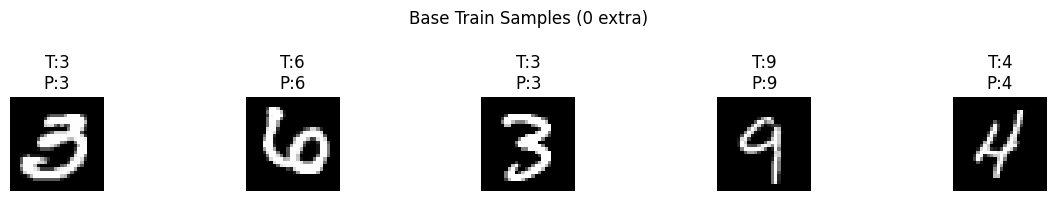

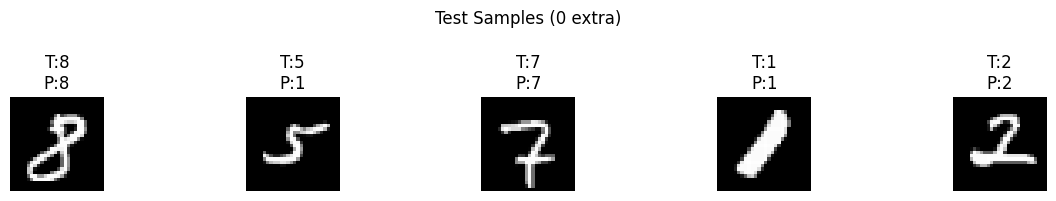

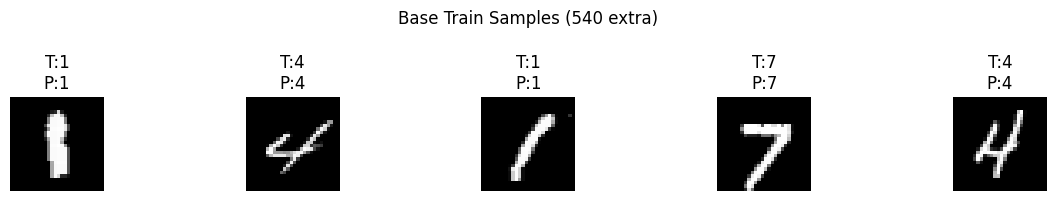

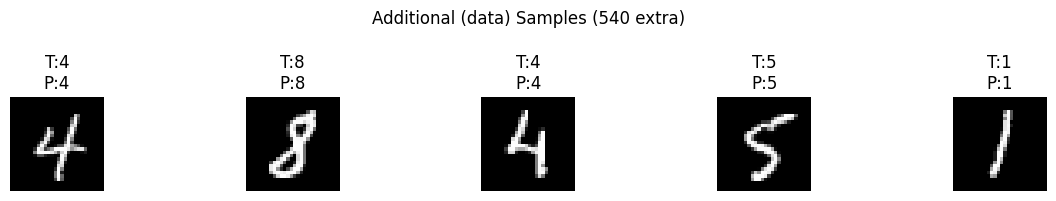

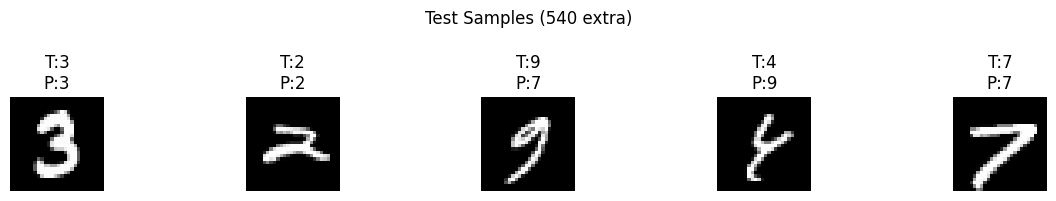

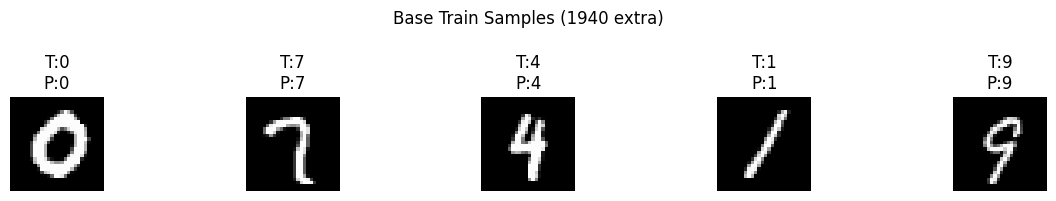

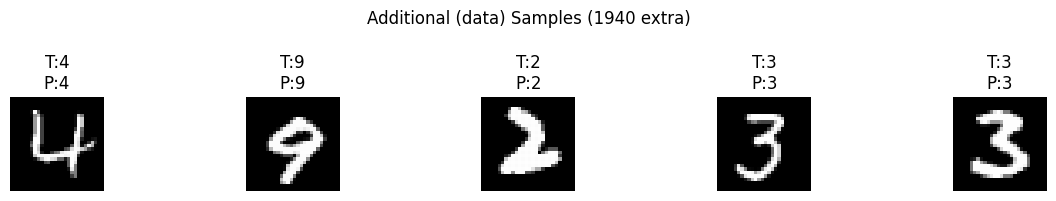

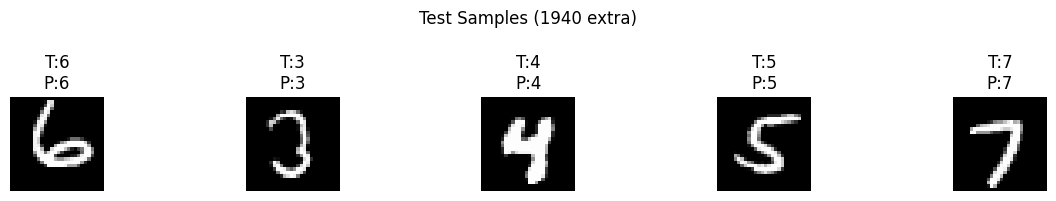

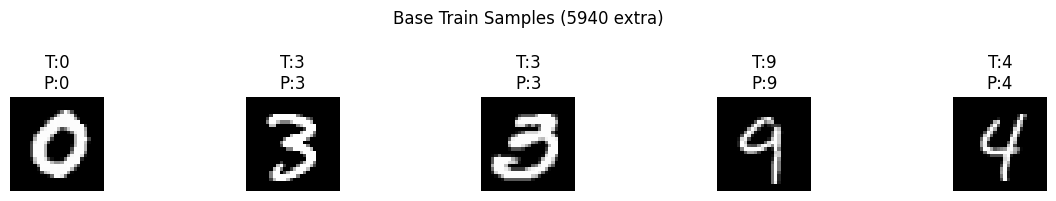

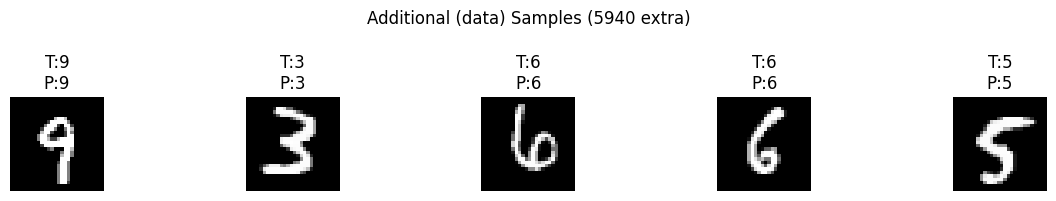

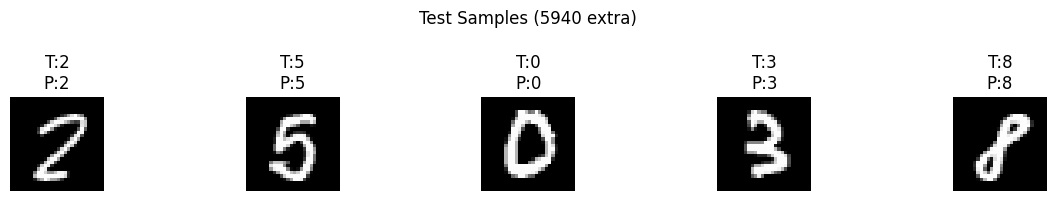

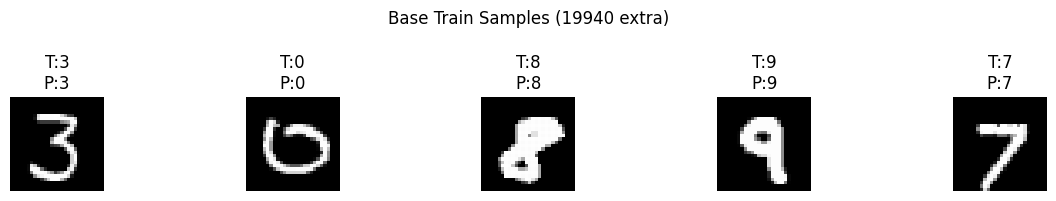

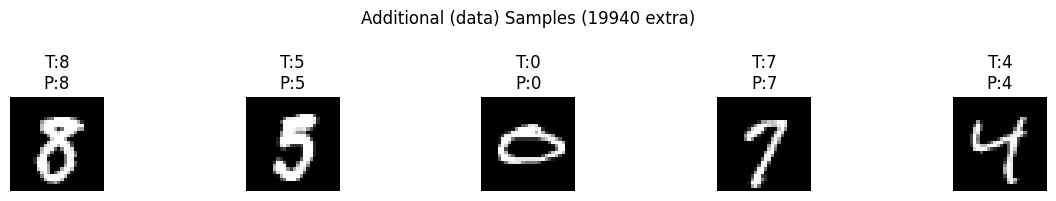

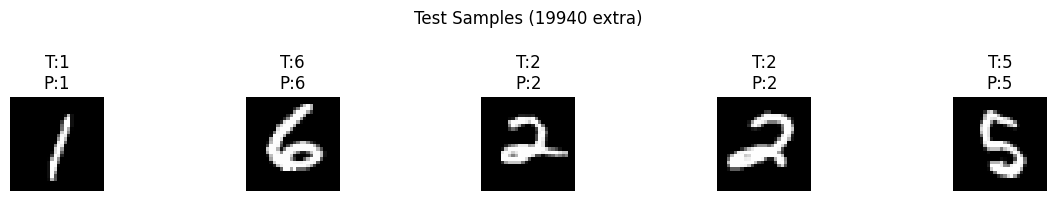

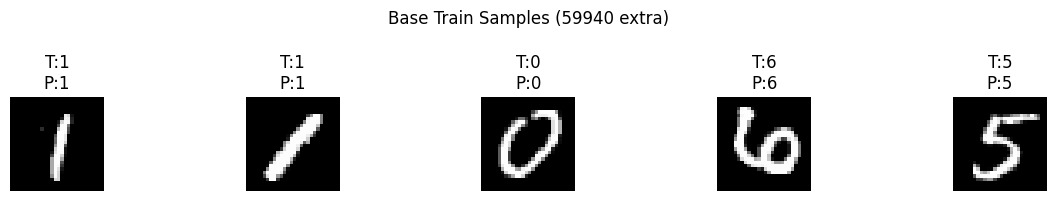

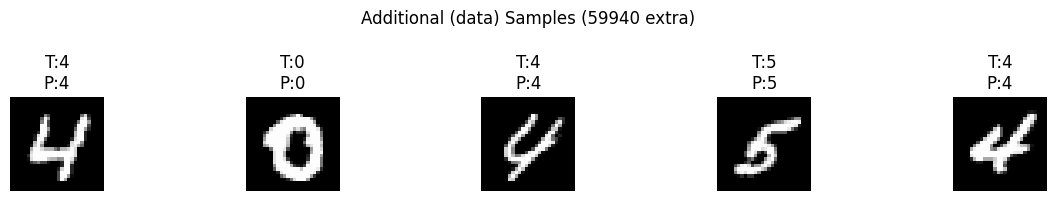

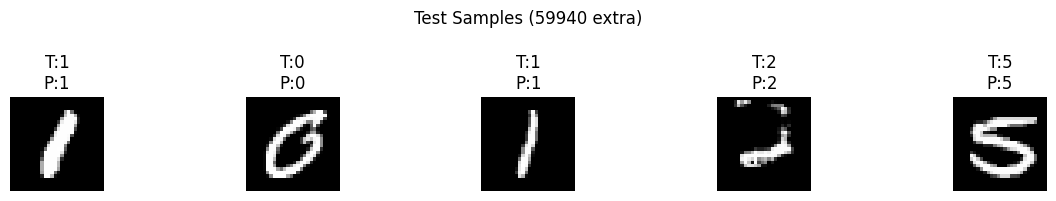

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
